In [ ]:
"""
Created by:
Nick Roseveare, Nov 2018, nicholasroseveare AT gmail.com
"""

### Model Training/Tuning 
   * start with small subset of data to get everything running and then move a larger data set
   * randomized training set using shuffle split et al. (https://scikit-learn.org/stable/modules/classes.html#module-sklearn.model_selection), want to ensure same ratio of classes in both training and test; in the case where a non-uniform (skewed class ratio) train/test data split is the only option, important to validate result with, for instance, F-1 score (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html) (take into account all entries in the confusion matrix, correct detect, correct reject, Type-I, Type-II   errors, at least for the two-class case)
   * add parameter regularization to penalize overfitting
   * update learning rate for longer lengths of training (reduce LR at each decade, e.g.)
   * hyperparamter tuning via grid-search or randomized optimization
   * NN optimization of backpropagation via Adam:  https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/, https://arxiv.org/pdf/1412.6980.pdf



In [1]:
import numpy as np
from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score, f1_score
import torch
import torch.utils.data
import torch.random
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim
from matplotlib import pyplot
import tqdm
import os

from eeg_project.read_data import (import_eeg_file, sample_file_list, get_all_metadata,
    my_read_eeg_generic, senlist_known, match_types, SAMP_FREQ, get_blocked_data,
    accumulate_subject_file_list, PSD_on_row_data, pass_through, zero, PSD_on_row_data, fft_on_row_data,
    eeg_half_half_alcoholic_all_subjects_obj_40, eeg_half_half_alcoholic_all_subjects_obj_100, 
    eeg_half_half_alcoholic_all_subjects_obj_tt_even_400)
from eeg_project.plot_data import plot_data_subject_dirs
from eeg_project.models import EEGNet, predict_twoclass_with_model, predict_with_model, train_EEG_net
import warnings
from sklearn.preprocessing import OneHotEncoder


metric_func_lut = dict(
    acc=accuracy_score,
    auc=roc_auc_score,
    recall=recall_score,
    precision=precision_score,
    f_1_meas=f1_score
)
PRF_metrics = ['recall', 'precision', 'f_1_meas']
basic_metrics = ['acc', 'auc']

In case of memory issues, can reduce batch-size to control how many samples get evaluated at one time. Ensure batch_size is a factor of length of samples so no samples are missed.

loss:1.12, acc:[1.00|0.56], lr[1e-05] : 100%|██████████| 25/25 [00:10<00:00,  2.35it/s]  

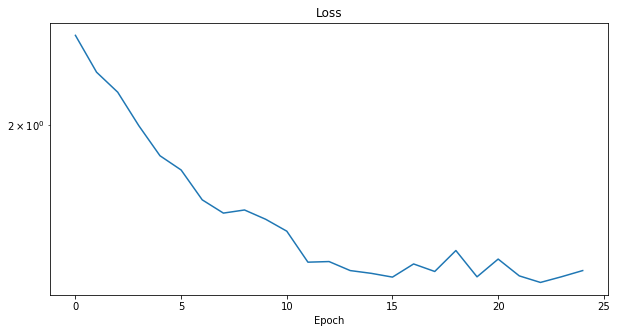

acc 0


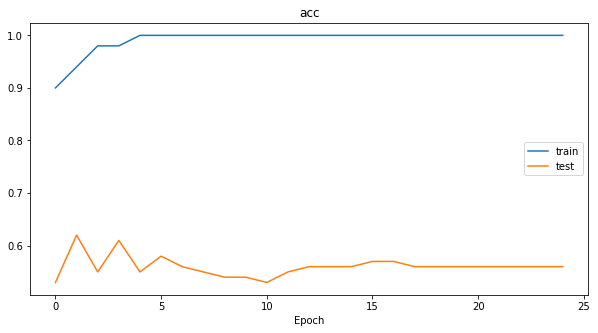

auc 1


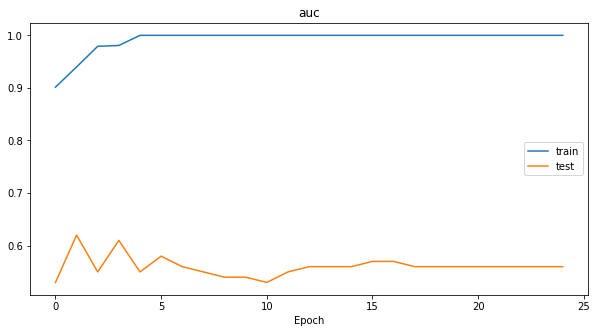

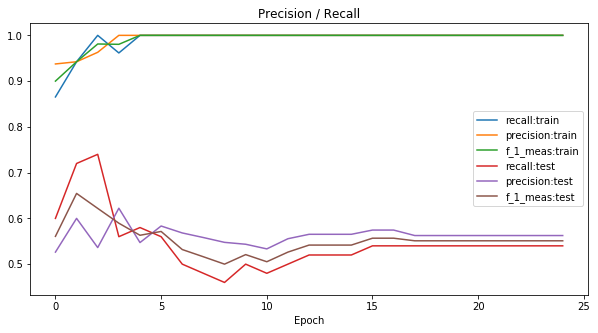

In [2]:
# Generate random data as an initial test
# Datatype - float32 (both X and Y) <br>
# X.shape - (#samples, 1, #timepoints,  #channels) <br>
# Y.shape - (#samples)
T, C = 128, 64
num_subjects = 100
X_train = torch.from_numpy(np.random.rand(num_subjects, 1, T, C).astype('float32')) # np.random.rand generates between [0, 1)
y_train = torch.from_numpy(np.round(np.random.rand(num_subjects).astype('float32'))) # binary data, so we round it to 0 or 1.

X_test = torch.from_numpy(np.random.rand(num_subjects, 1, T, C).astype('float32'))
y_test = torch.from_numpy(np.round(np.random.rand(num_subjects).astype('float32')))
data_tuple = (X_train, y_train, X_test, y_test, False)
net, params, loss, tr_met, tst_met = train_EEG_net(data_tuple, 25, regularization_param=.3)

  0%|          | 0/100 [00:00<?, ?it/s]

reading binary of organized data

   Xtrain:torch.Size([600, 1, 257, 64])
   ytrain:torch.Size([600])
   Xtest:torch.Size([600, 1, 257, 64])
   ytest:torch.Size([600])
   use 1-hot categorical feats: True


loss:1.07, acc:[1.00|0.98], lr[1e-05] : 100%|██████████| 100/100 [07:25<00:00,  4.45s/it]  

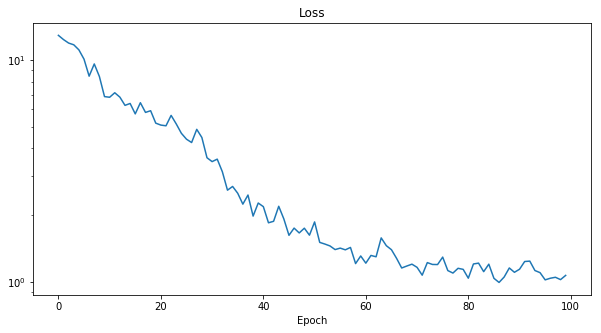

acc 0


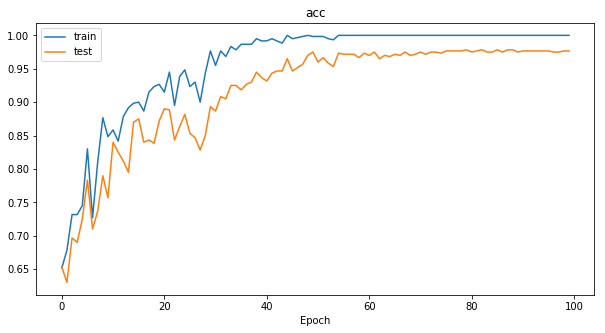

auc 1


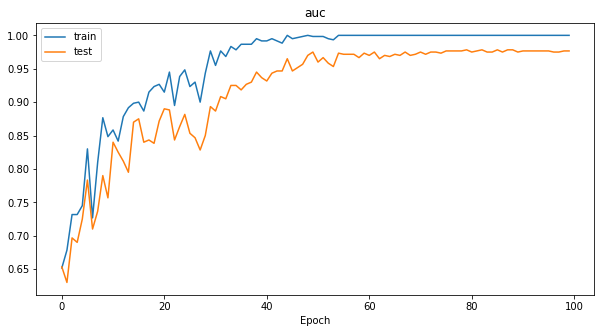

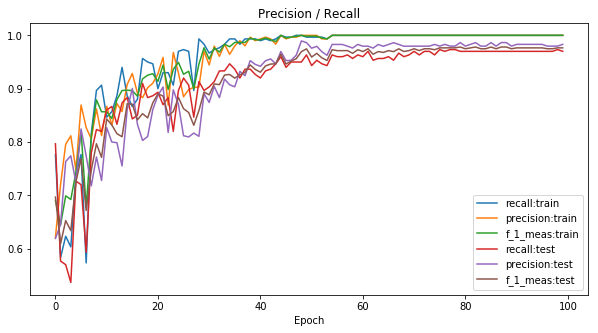

In [2]:
# if limitby, limit_mult_files, or balance_types not specified, just returned path/urls 
# of all LARGE data set files, sample_file_list uses `get_all_metadata()` function
file_list = sample_file_list()  
# limitby=dict(subject='co2a0000364'), balance_types=dict('alcoholic': 2))

use_onehost_categorical_feats, freq_data, multi_subject_id = True, False, False

name_suffix = ''
if multi_subject_id:
    name_suffix += '.multiclass'
if use_onehost_categorical_feats:
    name_suffix += '.onehot_catfeats'
if freq_data:
    name_suffix += '.fft'

data_tuple = get_blocked_data(file_list, 
    use_onehot_cat_feat=use_onehost_categorical_feats,
    multiclass=multi_subject_id,
    process_data=(fft_on_row_data if freq_data else pass_through), 
    pickle_name=f'eeg_all_data_medium_size_1200{name_suffix}.bin')

net, params, loss, tr_met, tst_met = train_EEG_net(data_tuple, 100)

  0%|          | 0/300 [00:00<?, ?it/s]

reading binary of organized data from: /Users/nick/Documents/Work/Projects/Interview_problems/TruU/eeg_ML/eeg_all_data_medium_size_1200.multiclass.onehot_catfeats.bin

   Xtrain:torch.Size([600, 1, 257, 64])
   ytrain:torch.Size([600, 20])
   Xtest:torch.Size([600, 1, 257, 64])
   ytest:torch.Size([600, 20])
   is multi-class: True  [20-class]
   use 1-hot categorical feats: True


loss:56.9, acc:[0.05|0.05], lr[1e-05] : 100%|██████████| 300/300 [22:50<00:00,  4.57s/it]  

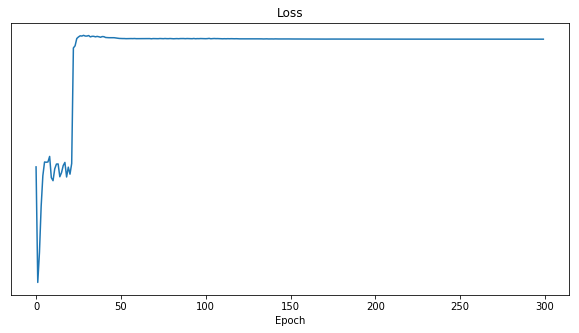

acc 0


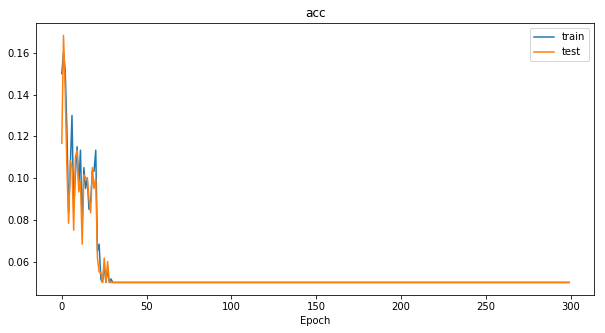

In [2]:
file_list = sample_file_list()  
use_onehost_categorical_feats, freq_data, multi_subject_id = True, False, True

name_suffix = ''
if multi_subject_id:
    name_suffix += '.multiclass'
if use_onehost_categorical_feats:
    name_suffix += '.onehot_catfeats'
if freq_data:
    name_suffix += '.fft'

data_tuple = get_blocked_data(file_list, 
    use_onehot_cat_feat=use_onehost_categorical_feats,
    multiclass=multi_subject_id,
    process_data=(fft_on_row_data if freq_data else pass_through), 
    pickle_name=f'eeg_all_data_medium_size_1200{name_suffix}.bin')

net, params, loss, tr_met, tst_met = train_EEG_net(data_tuple, 300)